In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

import time

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)


In [20]:
train_X = pd.read_csv('./intermediate/train.csv') 
train_y = pd.read_csv('./intermediate/target.csv', header=-1)
test_X = pd.read_csv('./intermediate/test.csv')
ids = pd.read_csv('./intermediate/sample_submission.csv')['card_id']

df_train_columns = [c for c in train_X.columns if c not in ['outliers']]

model_fn = './models/nn.pt'

In [21]:
n_samples, n_feature = train_X.shape

D_IN, H_1, H_2, H_3, H_4, D_OUT = n_feature, 1000, 500, 100, 10, 1

epochs = 100
batch_size = 128
learning_rate = 0.0001
early_stop_rounds = 10000

model = torch.nn.Sequential(
        torch.nn.Linear(D_IN, H_1),
        torch.nn.ReLU(),
        torch.nn.Linear(H_1, H_2),
        torch.nn.ReLU(),
        torch.nn.Linear(H_2, H_3),   
        torch.nn.ReLU(),
        torch.nn.Linear(H_3, H_4), 
        torch.nn.ReLU(),
        torch.nn.Linear(H_4, D_OUT)        
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = torch.nn.MSELoss()

In [22]:
def batch_iter(X, y, batch_size=64,shuffle=True):
    N = len(X)
    num_batch = int((N - 1) / batch_size) + 1
    
    if shuffle:
        indices = np.random.permutation(np.arange(N))
        X_shuffle = X
        y_shuffle = y
    else:
        X_shuffle = X
        y_shuffle = y
        
    for i in range(num_batch):
        start_idx = i * batch_size
        end_idx = min((i+1) * batch_size, N)
        
        yield torch.tensor(X_shuffle[start_idx: end_idx].values, dtype=torch.float), torch.tensor(y_shuffle[start_idx: end_idx].values, dtype=torch.float)

In [23]:
def timeSince(start):
    return time.time() - start

In [24]:
best_loss = float('inf')
early_stop_count = 0
start = time.time()

losses = []

for epoch in range(epochs):

    idx = 0
    
    for X_batch, y_batch in batch_iter(train_X[df_train_columns], train_y, batch_size, True):
        early_stop_count += 1
        if early_stop_count >= early_stop_rounds:
            break

        y_pred = model(X_batch)        
        loss = loss_fn(y_pred, y_batch)
        
        if loss < best_loss:
            best_loss = loss.item()
            torch.save(model, model_fn)
            early_stop_count = 0
        
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
        
        idx += 1
        
        if idx % 100 == 0:
            losses.append(loss.item())
            print('%s, %d epoch, %d index, %f loss' % (timeSince(start), epoch, idx, loss.item()))            
        
    
    if early_stop_count >= early_stop_rounds:
        break

1.1214611530303955, 0 epoch, 100 index, 396672640.000000 loss
2.302917003631592, 0 epoch, 200 index, 43689348.000000 loss
3.2204580307006836, 0 epoch, 300 index, 26297768.000000 loss
4.054245948791504, 0 epoch, 400 index, 28694296.000000 loss
4.896409273147583, 0 epoch, 500 index, 36408704.000000 loss
5.75713324546814, 0 epoch, 600 index, 14985452544.000000 loss
6.595407247543335, 0 epoch, 700 index, 305557280.000000 loss
7.509709119796753, 0 epoch, 800 index, 6261730.000000 loss
8.588885068893433, 0 epoch, 900 index, 1265389.000000 loss
9.572293996810913, 0 epoch, 1000 index, 3309580.250000 loss
10.578408002853394, 0 epoch, 1100 index, 64471868.000000 loss
11.640780210494995, 0 epoch, 1200 index, 369574976.000000 loss
12.70796012878418, 0 epoch, 1300 index, 5960870.000000 loss
14.060295104980469, 0 epoch, 1400 index, 5764059.000000 loss
15.583823204040527, 0 epoch, 1500 index, 187959904.000000 loss
18.193169116973877, 1 epoch, 100 index, 3238067.750000 loss
19.756131172180176, 1 epoch

316.1618928909302, 9 epoch, 900 index, 29.127771 loss
319.44307112693787, 9 epoch, 1000 index, 11.334746 loss
322.74608421325684, 9 epoch, 1100 index, 2.430353 loss
326.0425522327423, 9 epoch, 1200 index, 53.694870 loss
329.3793852329254, 9 epoch, 1300 index, 19.493299 loss
333.0939242839813, 9 epoch, 1400 index, 11.738482 loss
336.4283289909363, 9 epoch, 1500 index, 11.268620 loss
342.42367005348206, 10 epoch, 100 index, 19.901325 loss
345.87438106536865, 10 epoch, 200 index, 19.673073 loss
350.00575494766235, 10 epoch, 300 index, 3.314114 loss
353.6437931060791, 10 epoch, 400 index, 20.517151 loss
356.652713060379, 10 epoch, 500 index, 11.412865 loss
359.6305160522461, 10 epoch, 600 index, 3.537695 loss
362.6021342277527, 10 epoch, 700 index, 11.169668 loss
365.5728793144226, 10 epoch, 800 index, 20.160534 loss
368.54530811309814, 10 epoch, 900 index, 29.127701 loss
371.76265716552734, 10 epoch, 1000 index, 11.334721 loss
375.1176121234894, 10 epoch, 1100 index, 2.430362 loss
378.827

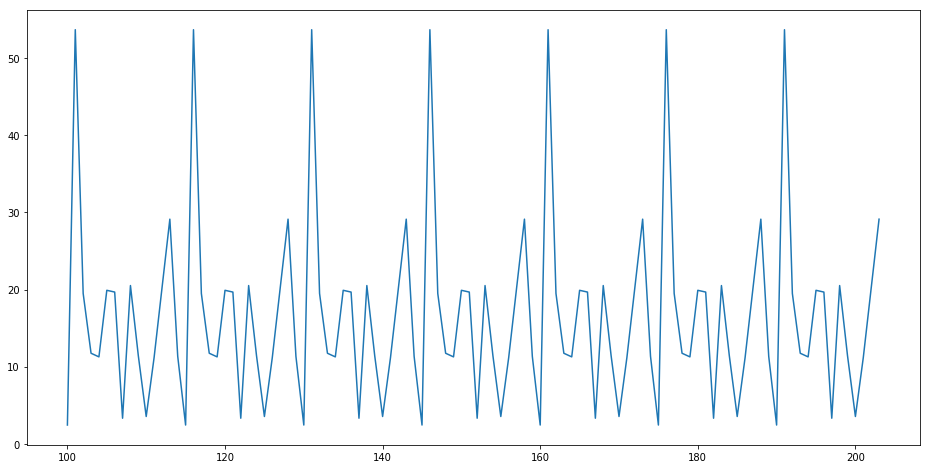

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(range(100, len(losses)), losses[100:])
plt.show()

In [26]:
model = torch.load(model_fn)
output = model(torch.tensor(test_X.values, dtype=torch.float))

sub_df = pd.DataFrame({"card_id": ids.values})
sub_df["target"] = output.detach().numpy()
sub_df.to_csv("./output/nn.csv", index=False)